# Nucleus Size Analysis for ML Optimization

This notebook analyzes nucleus sizes across different event types (stable, mitotic, death) to:
1. **Determine optimal crop sizes** for ML models
2. **Analyze size distributions** by event type
3. **Identify outliers** and size variations
4. **Provide recommendations** for ML preprocessing

## Key Questions:
- What is the average nucleus size for each event type?
- What crop size captures 95% of nuclei without excessive padding?
- How does nucleus size vary across time series?
- Are there size-based features that could improve ML performance?

In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tifffile
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Add the python directory to the path
python_dir = os.path.join(os.path.dirname(os.getcwd()), 'python')
if python_dir not in sys.path:
    sys.path.append(python_dir)

from nucleus_extractor_manager import (
    NucleusExtractorManager,
    NucleusExtractorConfig,
)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("📊 Nucleus Size Analysis Toolkit Loaded")
print("🎯 Goal: Optimize ML model input sizes and preprocessing")

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

📊 Nucleus Size Analysis Toolkit Loaded
🎯 Goal: Optimize ML model input sizes and preprocessing


## 1. Data Collection

First, let's collect nucleus size data from the extracted dataset and raw data sources.

In [2]:
# Available datasets
datasets = {
    "230212_stack6": "/mnt/ceph/users/lbrown/MouseData/Rebecca/230212_stack6/",
    "220321_stack11": "/mnt/ceph/users/lbrown/MouseData/Rebecca/220321_stack11/", 
    "221016_FUCCI_Nanog_stack_3": "/mnt/ceph/users/lbrown/Labels3DMouse/Abhishek/RebeccaData/221016_FUCCI_Nanog_stack_3/",
}

# Path to extracted nuclei data
project_root = Path(os.getcwd()).parent.parent
nuclei_data_path = project_root / "data" / "nuclei_state_dataset"

print(f"📂 Available datasets: {list(datasets.keys())}")
print(f"📁 Extracted nuclei data: {nuclei_data_path}")
print(f"🔍 Checking extracted data availability...")

if nuclei_data_path.exists():
    event_types = [d.name for d in nuclei_data_path.iterdir() if d.is_dir()]
    print(f"✅ Found event types: {event_types}")
    
    for event_type in event_types:
        event_path = nuclei_data_path / event_type
        nucleus_folders = [d for d in event_path.iterdir() if d.is_dir()]
        print(f"   📊 {event_type}: {len(nucleus_folders)} nucleus samples")
else:
    print("⚠️  No extracted data found. Will analyze from raw data sources.")

📂 Available datasets: ['230212_stack6', '220321_stack11', '221016_FUCCI_Nanog_stack_3']
📁 Extracted nuclei data: /mnt/home/dchhantyal/3d-cnn-classification/data/nuclei_state_dataset
🔍 Checking extracted data availability...
✅ Found event types: ['mitotic']
   📊 mitotic: 5 nucleus samples


## 2. Size Data Collection Functions

In [3]:
def collect_size_data_from_extracted(nuclei_data_path):
    """Collect size data from already extracted nuclei"""
    size_data = []
    
    if not nuclei_data_path.exists():
        print("❌ No extracted data found")
        return pd.DataFrame()
    
    print("📊 Collecting size data from extracted nuclei...")
    
    for event_type_dir in nuclei_data_path.iterdir():
        if not event_type_dir.is_dir():
            continue
            
        event_type = event_type_dir.name
        print(f"   🔍 Processing {event_type} nuclei...")
        
        for nucleus_dir in event_type_dir.iterdir():
            if not nucleus_dir.is_dir():
                continue
                
            # Parse nucleus directory name
            dir_parts = nucleus_dir.name.split('_')
            if len(dir_parts) >= 4:
                stack_id = dir_parts[0]
                nucleus_id = dir_parts[1].replace('nucleus', '')
                frame_id = dir_parts[2].replace('frame', '')
                nuclei_count = dir_parts[3].replace('count', '')
            else:
                continue
                
            # Load nucleus metadata
            metadata_file = nucleus_dir / "nucleus_metadata.json"
            if metadata_file.exists():
                with open(metadata_file) as f:
                    metadata = json.load(f)
                    
                # Collect data from each time point
                for time_point in ['previous', 'current', 'next']:
                    time_dir = nucleus_dir / time_point
                    if time_dir.exists():
                        metadata_path = time_dir / "metadata.json"
                        if metadata_path.exists():
                            with open(metadata_path) as f:
                                time_metadata = json.load(f)
                                
                            # Extract size information
                            size_info = {
                                'stack_id': stack_id,
                                'nucleus_id': int(nucleus_id),
                                'frame_id': int(frame_id),
                                'event_type': event_type,
                                'time_point': time_point,
                                'nucleus_present': time_metadata.get('nucleus_present', False),
                                'original_volume': time_metadata.get('stats', {}).get('original_volume', 0),
                                'cleaned_volume': time_metadata.get('stats', {}).get('cleaned_volume', 0),
                                'volume_change': time_metadata.get('stats', {}).get('volume_change', 0),
                                'volume_change_percent': time_metadata.get('stats', {}).get('volume_change_percent', 0),
                                'nuclei_in_frame': int(nuclei_count),
                                'is_mitotic': metadata.get('is_mitotic', 0),
                                'is_death': metadata.get('is_death', 0),
                            }
                            
                            # Add bounding box dimensions if available
                            if 'bounding_box' in metadata:
                                bbox = metadata['bounding_box']
                                if len(bbox) == 6:
                                    z_min, z_max, y_min, y_max, x_min, x_max = bbox
                                    size_info.update({
                                        'bbox_z_size': z_max - z_min + 1,
                                        'bbox_y_size': y_max - y_min + 1,
                                        'bbox_x_size': x_max - x_min + 1,
                                        'bbox_volume': (z_max - z_min + 1) * (y_max - y_min + 1) * (x_max - x_min + 1)
                                    })
                            
                            size_data.append(size_info)
    
    df = pd.DataFrame(size_data)
    print(f"✅ Collected {len(df)} size measurements")
    return df

In [4]:
def collect_size_data_from_raw(dataset_path, max_samples=200):
    """Collect size data directly from raw dataset"""
    print(f"📊 Collecting size data from raw dataset: {dataset_path}")
    
    # Initialize nucleus extractor
    config = NucleusExtractorConfig()
    manager = NucleusExtractorManager(dataset_path, config)
    
    if not manager.metadata or 'classes' not in manager.metadata:
        print("❌ No classification data found")
        return pd.DataFrame()
    
    df_classes = manager.metadata['classes']
    print(f"📋 Found {len(df_classes)} classified nuclei")
    
    # Sample data if too large
    if len(df_classes) > max_samples:
        df_classes = df_classes.sample(n=max_samples, random_state=42)
        print(f"🎲 Sampled {max_samples} nuclei for analysis")
    
    size_data = []
    
    for idx, row in df_classes.iterrows():
        nucleus_id = int(row['nucleus_id'])
        frame = int(row['frame'])
        is_mitotic = int(row['mitotic'])
        is_death = int(row['death'])
        
        # Determine event type
        if is_mitotic and is_death:
            event_type = 'mitotic_death'
        elif is_mitotic:
            event_type = 'mitotic'
        elif is_death:
            event_type = 'death'
        else:
            event_type = 'stable'
            
        # Load label file to measure nucleus
        label_files = list(manager.lbl_dir.glob(f"label_reg8_{frame}.tif"))
        if label_files:
            try:
                label_img = tifffile.imread(label_files[0])
                nucleus_mask = label_img == nucleus_id
                volume = np.sum(nucleus_mask)
                
                if volume > 0:
                    # Get bounding box
                    positions = np.where(nucleus_mask)
                    z_min, z_max = positions[0].min(), positions[0].max()
                    y_min, y_max = positions[1].min(), positions[1].max()
                    x_min, x_max = positions[2].min(), positions[2].max()
                    
                    # Count nuclei in frame
                    unique_nuclei = np.unique(label_img)
                    nuclei_in_frame = len(unique_nuclei[unique_nuclei > 0])
                    
                    size_info = {
                        'dataset': Path(dataset_path).name,
                        'nucleus_id': nucleus_id,
                        'frame_id': frame,
                        'event_type': event_type,
                        'volume': volume,
                        'bbox_z_size': z_max - z_min + 1,
                        'bbox_y_size': y_max - y_min + 1,
                        'bbox_x_size': x_max - x_min + 1,
                        'bbox_volume': (z_max - z_min + 1) * (y_max - y_min + 1) * (x_max - x_min + 1),
                        'nuclei_in_frame': nuclei_in_frame,
                        'is_mitotic': is_mitotic,
                        'is_death': is_death,
                    }
                    
                    size_data.append(size_info)
                    
            except Exception as e:
                print(f"⚠️  Error processing nucleus {nucleus_id} in frame {frame}: {e}")
                continue
    
    df = pd.DataFrame(size_data)
    print(f"✅ Collected {len(df)} size measurements from raw data")
    return df

## 3. Collect All Size Data

In [5]:
# Collect size data from multiple sources
all_size_data = []

# First, try to collect from extracted data
print("🔍 Step 1: Collecting from extracted nuclei data...")
extracted_df = collect_size_data_from_extracted(nuclei_data_path)
if not extracted_df.empty:
    all_size_data.append(extracted_df)
    print(f"✅ Collected {len(extracted_df)} measurements from extracted data")

# Then collect from raw datasets
print("\n🔍 Step 2: Collecting from raw datasets...")
for dataset_name, dataset_path in datasets.items():
    if Path(dataset_path).exists():
        print(f"\n📊 Processing {dataset_name}...")
        raw_df = collect_size_data_from_raw(dataset_path, max_samples=100)
        if not raw_df.empty:
            all_size_data.append(raw_df)
            print(f"✅ Added {len(raw_df)} measurements from {dataset_name}")
    else:
        print(f"⚠️  Dataset {dataset_name} not accessible: {dataset_path}")

# Combine all data
if all_size_data:
    combined_df = pd.concat(all_size_data, ignore_index=True)
    print(f"\n🎯 Total size measurements collected: {len(combined_df)}")
    print(f"📊 Event type distribution:")
    print(combined_df['event_type'].value_counts())
else:
    print("❌ No size data could be collected")
    combined_df = pd.DataFrame()

🔍 Step 1: Collecting from extracted nuclei data...
📊 Collecting size data from extracted nuclei...
   🔍 Processing mitotic nuclei...
✅ Collected 15 size measurements
✅ Collected 15 measurements from extracted data

🔍 Step 2: Collecting from raw datasets...

📊 Processing 230212_stack6...
📊 Collecting size data from raw dataset: /mnt/ceph/users/lbrown/MouseData/Rebecca/230212_stack6/
📂 Loading metadata from /mnt/ceph/users/lbrown/MouseData/Rebecca/230212_stack6
📂 Loading classification data from: /mnt/ceph/users/lbrown/MouseData/Rebecca/230212_stack6/DeathAndMitoticClass.txt
✅ Loaded 122 classifications
Columns: ['frame', 'nucleus_id', 'mitotic', 'death']

Data distribution:
Frames: 25 - 238
Nucleus IDs: 63 unique
Mitotic events: 100
Death events: 22
✅ Loaded 122 classifications
📋 Found 122 classified nuclei
🎲 Sampled 100 nuclei for analysis
✅ Collected 100 size measurements from raw data
✅ Added 100 measurements from 230212_stack6
⚠️  Dataset 220321_stack11 not accessible: /mnt/ceph/use

## 4. Size Distribution Analysis

In [6]:
if not combined_df.empty:
    # Focus on nuclei that are present (volume > 0)
    present_nuclei = combined_df[combined_df.get('volume', combined_df.get('original_volume', 0)) > 0].copy()
    
    # Standardize volume column name
    if 'volume' not in present_nuclei.columns and 'original_volume' in present_nuclei.columns:
        present_nuclei['volume'] = present_nuclei['original_volume']
    
    print(f"📊 Analyzing {len(present_nuclei)} nuclei with positive volume")
    
    # Basic statistics by event type
    print("\n📈 Volume Statistics by Event Type:")
    print("=" * 60)
    
    volume_stats = present_nuclei.groupby('event_type')['volume'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: np.percentile(x, 25),
        lambda x: np.percentile(x, 75),
        lambda x: np.percentile(x, 95)
    ]).round(2)
    
    volume_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q25', 'Q75', 'P95']
    print(volume_stats)
    
    # Bounding box statistics if available
    if 'bbox_volume' in present_nuclei.columns:
        print("\n📦 Bounding Box Statistics by Event Type:")
        print("=" * 60)
        
        bbox_stats = present_nuclei.groupby('event_type')[['bbox_z_size', 'bbox_y_size', 'bbox_x_size', 'bbox_volume']].agg([
            'mean', 'median', 'std',
            lambda x: np.percentile(x, 95)
        ]).round(2)
        
        bbox_stats.columns = ['Mean', 'Median', 'Std', 'P95']
        print(bbox_stats)
else:
    print("❌ No data available for analysis")

📊 Analyzing 193 nuclei with positive volume

📈 Volume Statistics by Event Type:
            Count     Mean  Median     Std    Min     Max      Q25     Q75  \
event_type                                                                   
death          19  1000.79   742.0  561.22  210.0  2200.0   565.00  1509.5   
mitotic       174  1591.20  1499.0  606.39  230.0  3580.0  1153.25  1977.5   

                P95  
event_type           
death       1741.90  
mitotic     2756.05  

📦 Bounding Box Statistics by Event Type:


ValueError: Length mismatch: Expected axis has 16 elements, new values have 4 elements

## 5. Visualization of Size Distributions

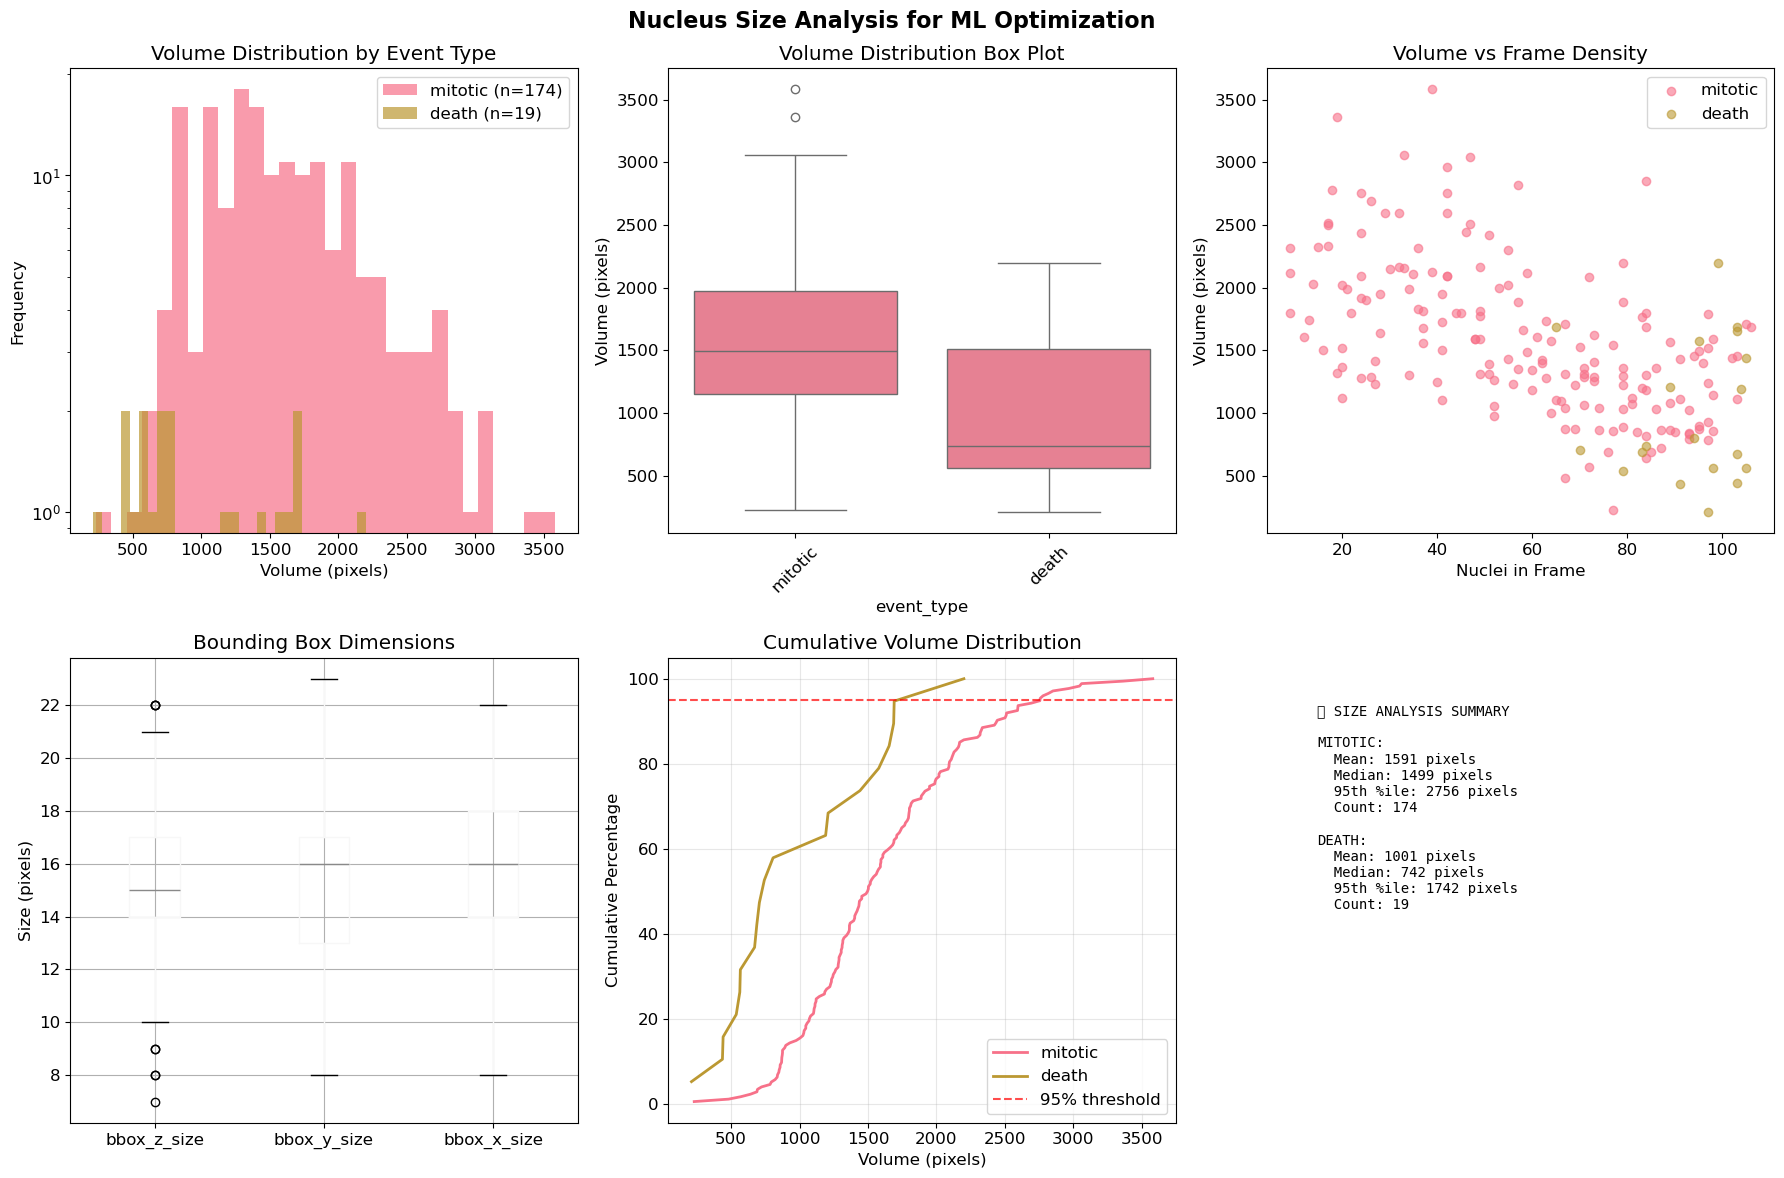

In [7]:
if not combined_df.empty and len(present_nuclei) > 0:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Nucleus Size Analysis for ML Optimization', fontsize=16, fontweight='bold')
    
    # 1. Volume distribution by event type
    ax1 = axes[0, 0]
    for event_type in present_nuclei['event_type'].unique():
        data = present_nuclei[present_nuclei['event_type'] == event_type]['volume']
        ax1.hist(data, alpha=0.7, label=f'{event_type} (n={len(data)})', bins=30)
    ax1.set_xlabel('Volume (pixels)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Volume Distribution by Event Type')
    ax1.legend()
    ax1.set_yscale('log')
    
    # 2. Box plot of volumes
    ax2 = axes[0, 1]
    sns.boxplot(data=present_nuclei, x='event_type', y='volume', ax=ax2)
    ax2.set_title('Volume Distribution Box Plot')
    ax2.set_ylabel('Volume (pixels)')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Volume vs nuclei count scatter
    ax3 = axes[0, 2]
    nuclei_col = 'nuclei_in_frame' if 'nuclei_in_frame' in present_nuclei.columns else 'nuclei_in_frame'
    if nuclei_col in present_nuclei.columns:
        for event_type in present_nuclei['event_type'].unique():
            data = present_nuclei[present_nuclei['event_type'] == event_type]
            ax3.scatter(data[nuclei_col], data['volume'], alpha=0.6, label=event_type)
        ax3.set_xlabel('Nuclei in Frame')
        ax3.set_ylabel('Volume (pixels)')
        ax3.set_title('Volume vs Frame Density')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'Nuclei count data\nnot available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Volume vs Frame Density')
    
    # 4. Bounding box dimensions if available
    ax4 = axes[1, 0]
    if 'bbox_z_size' in present_nuclei.columns:
        bbox_dims = present_nuclei[['bbox_z_size', 'bbox_y_size', 'bbox_x_size']]
        bbox_dims.boxplot(ax=ax4)
        ax4.set_title('Bounding Box Dimensions')
        ax4.set_ylabel('Size (pixels)')
    else:
        ax4.text(0.5, 0.5, 'Bounding box data\nnot available', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Bounding Box Dimensions')
    
    # 5. Cumulative distribution for crop size optimization
    ax5 = axes[1, 1]
    for event_type in present_nuclei['event_type'].unique():
        data = present_nuclei[present_nuclei['event_type'] == event_type]['volume'].sort_values()
        cumulative = np.arange(1, len(data) + 1) / len(data) * 100
        ax5.plot(data, cumulative, label=f'{event_type}', linewidth=2)
    
    ax5.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
    ax5.set_xlabel('Volume (pixels)')
    ax5.set_ylabel('Cumulative Percentage')
    ax5.set_title('Cumulative Volume Distribution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Volume statistics summary
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Create summary text
    summary_text = "📊 SIZE ANALYSIS SUMMARY\n\n"
    
    for event_type in present_nuclei['event_type'].unique():
        data = present_nuclei[present_nuclei['event_type'] == event_type]['volume']
        summary_text += f"{event_type.upper()}:\n"
        summary_text += f"  Mean: {data.mean():.0f} pixels\n"
        summary_text += f"  Median: {data.median():.0f} pixels\n"
        summary_text += f"  95th %ile: {np.percentile(data, 95):.0f} pixels\n"
        summary_text += f"  Count: {len(data)}\n\n"
    
    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, 
             fontfamily='monospace', fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

## 6. ML Optimization Recommendations

In [8]:
if not combined_df.empty and len(present_nuclei) > 0:
    print("🎯 ML OPTIMIZATION RECOMMENDATIONS")
    print("=" * 60)
    
    # Calculate key metrics
    overall_stats = present_nuclei['volume'].describe()
    p95_volume = np.percentile(present_nuclei['volume'], 95)
    p99_volume = np.percentile(present_nuclei['volume'], 99)
    
    print(f"\n📊 OVERALL VOLUME STATISTICS:")
    print(f"   • Total nuclei analyzed: {len(present_nuclei):,}")
    print(f"   • Mean volume: {overall_stats['mean']:.0f} pixels")
    print(f"   • Median volume: {overall_stats['50%']:.0f} pixels")
    print(f"   • 95th percentile: {p95_volume:.0f} pixels")
    print(f"   • 99th percentile: {p99_volume:.0f} pixels")
    
    # Estimate cubic crop sizes
    def volume_to_cube_size(volume):
        """Estimate cubic crop size from volume"""
        return int(np.ceil(volume ** (1/3)))
    
    cube_95 = volume_to_cube_size(p95_volume)
    cube_99 = volume_to_cube_size(p99_volume)
    cube_mean = volume_to_cube_size(overall_stats['mean'])
    
    print(f"\n📦 RECOMMENDED CROP SIZES (cubic):")
    print(f"   • Conservative (95% coverage): {cube_95}×{cube_95}×{cube_95}")
    print(f"   • Aggressive (99% coverage): {cube_99}×{cube_99}×{cube_99}")
    print(f"   • Average-based: {cube_mean}×{cube_mean}×{cube_mean}")
    
    # Bounding box recommendations if available
    if 'bbox_z_size' in present_nuclei.columns:
        bbox_95_z = np.percentile(present_nuclei['bbox_z_size'], 95)
        bbox_95_y = np.percentile(present_nuclei['bbox_y_size'], 95)
        bbox_95_x = np.percentile(present_nuclei['bbox_x_size'], 95)
        
        print(f"\n📐 BOUNDING BOX RECOMMENDATIONS (95% coverage):")
        print(f"   • Z dimension: {bbox_95_z:.0f} pixels")
        print(f"   • Y dimension: {bbox_95_y:.0f} pixels")
        print(f"   • X dimension: {bbox_95_x:.0f} pixels")
        print(f"   • Recommended crop: {int(bbox_95_z)}×{int(bbox_95_y)}×{int(bbox_95_x)}")
    
    # Event-specific recommendations
    print(f"\n🎯 EVENT-SPECIFIC RECOMMENDATIONS:")
    for event_type in present_nuclei['event_type'].unique():
        event_data = present_nuclei[present_nuclei['event_type'] == event_type]
        event_p95 = np.percentile(event_data['volume'], 95)
        event_cube = volume_to_cube_size(event_p95)
        
        print(f"   • {event_type.upper()}:")
        print(f"     - Sample count: {len(event_data)}")
        print(f"     - 95th percentile volume: {event_p95:.0f} pixels")
        print(f"     - Recommended cube size: {event_cube}×{event_cube}×{event_cube}")
    
    # ML preprocessing suggestions
    print(f"\n🤖 ML PREPROCESSING SUGGESTIONS:")
    print(f"   • Use adaptive crop sizes based on event type")
    print(f"   • Consider volume as a feature (correlation with event type)")
    print(f"   • Apply padding strategy for smaller nuclei")
    print(f"   • Consider down-sampling very large nuclei")
    
    if present_nuclei['volume'].std() / present_nuclei['volume'].mean() > 1.0:
        print(f"   • ⚠️  High volume variability detected - consider normalization")
    
    # Size-based features
    print(f"\n📈 POTENTIAL SIZE-BASED FEATURES:")
    print(f"   • Nucleus volume (raw feature)")
    print(f"   • Volume relative to frame average")
    print(f"   • Aspect ratios (if bounding box available)")
    print(f"   • Volume change over time series")
    
    # Statistical significance tests
    event_types = present_nuclei['event_type'].unique()
    if len(event_types) > 1:
        print(f"\n📊 STATISTICAL DIFFERENCES:")
        for i, et1 in enumerate(event_types):
            for et2 in event_types[i+1:]:
                data1 = present_nuclei[present_nuclei['event_type'] == et1]['volume']
                data2 = present_nuclei[present_nuclei['event_type'] == et2]['volume']
                
                if len(data1) > 5 and len(data2) > 5:
                    statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    print(f"   • {et1} vs {et2}: p={p_value:.4f} {significance}")
else:
    print("❌ No data available for recommendations")

🎯 ML OPTIMIZATION RECOMMENDATIONS

📊 OVERALL VOLUME STATISTICS:
   • Total nuclei analyzed: 193
   • Mean volume: 1533 pixels
   • Median volume: 1441 pixels
   • 95th percentile: 2717 pixels
   • 99th percentile: 3084 pixels

📦 RECOMMENDED CROP SIZES (cubic):
   • Conservative (95% coverage): 14×14×14
   • Aggressive (99% coverage): 15×15×15
   • Average-based: 12×12×12

📐 BOUNDING BOX RECOMMENDATIONS (95% coverage):
   • Z dimension: 19 pixels
   • Y dimension: 20 pixels
   • X dimension: 21 pixels
   • Recommended crop: 19×20×21

🎯 EVENT-SPECIFIC RECOMMENDATIONS:
   • MITOTIC:
     - Sample count: 174
     - 95th percentile volume: 2756 pixels
     - Recommended cube size: 15×15×15
   • DEATH:
     - Sample count: 19
     - 95th percentile volume: 1742 pixels
     - Recommended cube size: 13×13×13

🤖 ML PREPROCESSING SUGGESTIONS:
   • Use adaptive crop sizes based on event type
   • Consider volume as a feature (correlation with event type)
   • Apply padding strategy for smaller nu

## 7. Export Size Analysis Results

In [9]:
if not combined_df.empty and len(present_nuclei) > 0:
    # Create results directory
    results_dir = project_root / "analysis_results"
    results_dir.mkdir(exist_ok=True)
    
    # Save detailed size data
    size_data_file = results_dir / "nucleus_size_data.csv"
    present_nuclei.to_csv(size_data_file, index=False)
    print(f"💾 Saved detailed size data: {size_data_file}")
    
    # Save summary statistics
    summary_stats = present_nuclei.groupby('event_type')['volume'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: np.percentile(x, 25),
        lambda x: np.percentile(x, 50),
        lambda x: np.percentile(x, 75),
        lambda x: np.percentile(x, 95),
        lambda x: np.percentile(x, 99)
    ])
    summary_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q25', 'Q50', 'Q75', 'P95', 'P99']
    
    summary_file = results_dir / "size_statistics_summary.csv"
    summary_stats.to_csv(summary_file)
    print(f"📊 Saved summary statistics: {summary_file}")
    
    # Save ML recommendations as JSON
    recommendations = {
        "overall_stats": {
            "total_nuclei": len(present_nuclei),
            "mean_volume": float(present_nuclei['volume'].mean()),
            "median_volume": float(present_nuclei['volume'].median()),
            "p95_volume": float(np.percentile(present_nuclei['volume'], 95)),
            "p99_volume": float(np.percentile(present_nuclei['volume'], 99))
        },
        "recommended_crop_sizes": {
            "conservative_95": f"{cube_95}x{cube_95}x{cube_95}",
            "aggressive_99": f"{cube_99}x{cube_99}x{cube_99}",
            "average_based": f"{cube_mean}x{cube_mean}x{cube_mean}"
        },
        "event_specific": {}
    }
    
    for event_type in present_nuclei['event_type'].unique():
        event_data = present_nuclei[present_nuclei['event_type'] == event_type]
        event_p95 = np.percentile(event_data['volume'], 95)
        event_cube = volume_to_cube_size(event_p95)
        
        recommendations["event_specific"][event_type] = {
            "count": len(event_data),
            "mean_volume": float(event_data['volume'].mean()),
            "p95_volume": float(event_p95),
            "recommended_cube": f"{event_cube}x{event_cube}x{event_cube}"
        }
    
    recommendations_file = results_dir / "ml_optimization_recommendations.json"
    with open(recommendations_file, 'w') as f:
        json.dump(recommendations, f, indent=2)
    print(f"🎯 Saved ML recommendations: {recommendations_file}")
    
    print(f"\n✅ Analysis complete! Results saved in: {results_dir}")
else:
    print("❌ No data to export")

💾 Saved detailed size data: /mnt/home/dchhantyal/3d-cnn-classification/analysis_results/nucleus_size_data.csv
📊 Saved summary statistics: /mnt/home/dchhantyal/3d-cnn-classification/analysis_results/size_statistics_summary.csv
🎯 Saved ML recommendations: /mnt/home/dchhantyal/3d-cnn-classification/analysis_results/ml_optimization_recommendations.json

✅ Analysis complete! Results saved in: /mnt/home/dchhantyal/3d-cnn-classification/analysis_results


## 8. Advanced Size Analysis (Optional)

This section provides additional analysis for understanding nucleus size patterns.

In [10]:
if not combined_df.empty and len(present_nuclei) > 0:
    print("🔬 ADVANCED SIZE PATTERN ANALYSIS")
    print("=" * 50)
    
    # 1. Size correlation with frame density
    if 'nuclei_in_frame' in present_nuclei.columns:
        correlation = present_nuclei['volume'].corr(present_nuclei['nuclei_in_frame'])
        print(f"📊 Volume vs Frame Density Correlation: {correlation:.3f}")
        
        if abs(correlation) > 0.3:
            print(f"   → {'Strong' if abs(correlation) > 0.5 else 'Moderate'} correlation detected!")
    
    # 2. Size outlier detection
    Q1 = present_nuclei['volume'].quantile(0.25)
    Q3 = present_nuclei['volume'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = present_nuclei[(present_nuclei['volume'] < lower_bound) | 
                              (present_nuclei['volume'] > upper_bound)]
    
    print(f"\n🎯 OUTLIER ANALYSIS:")
    print(f"   • Total outliers: {len(outliers)} ({len(outliers)/len(present_nuclei)*100:.1f}%)")
    print(f"   • Small outliers (< {lower_bound:.0f}): {len(outliers[outliers['volume'] < lower_bound])}")
    print(f"   • Large outliers (> {upper_bound:.0f}): {len(outliers[outliers['volume'] > upper_bound])}")
    
    if len(outliers) > 0:
        print(f"\n🔍 Outlier Event Type Distribution:")
        outlier_dist = outliers['event_type'].value_counts()
        for event_type, count in outlier_dist.items():
            total_event = len(present_nuclei[present_nuclei['event_type'] == event_type])
            percentage = count / total_event * 100
            print(f"   • {event_type}: {count}/{total_event} ({percentage:.1f}%)")
    
    # 3. Temporal analysis if time series data available
    if 'time_point' in present_nuclei.columns:
        print(f"\n⏱️  TEMPORAL SIZE PATTERNS:")
        temporal_stats = present_nuclei.groupby(['event_type', 'time_point'])['volume'].mean().unstack()
        print(temporal_stats.round(1))
        
        # Look for size changes over time
        if 'current' in temporal_stats.columns:
            for event_type in temporal_stats.index:
                current_vol = temporal_stats.loc[event_type, 'current']
                if 'previous' in temporal_stats.columns:
                    prev_vol = temporal_stats.loc[event_type, 'previous']
                    if not pd.isna(prev_vol) and prev_vol > 0:
                        change = (current_vol - prev_vol) / prev_vol * 100
                        print(f"   • {event_type}: {change:+.1f}% volume change (prev→current)")

else:
    print("❌ No data available for advanced analysis")

🔬 ADVANCED SIZE PATTERN ANALYSIS
📊 Volume vs Frame Density Correlation: -0.572
   → Strong correlation detected!

🎯 OUTLIER ANALYSIS:
   • Total outliers: 2 (1.0%)
   • Small outliers (< -93): 0
   • Large outliers (> 3099): 2

🔍 Outlier Event Type Distribution:
   • mitotic: 2/174 (1.1%)

⏱️  TEMPORAL SIZE PATTERNS:
Empty DataFrame
Columns: []
Index: []


## Summary

This notebook provides comprehensive analysis of nucleus sizes to optimize ML model performance:

### Key Outputs:
1. **Size Statistics** by event type (stable, mitotic, death)
2. **Crop Size Recommendations** for different coverage levels (95%, 99%)
3. **Event-Specific Optimization** suggestions
4. **Statistical Analysis** of size differences between event types
5. **Outlier Detection** for data quality assessment

### Files Generated:
- `nucleus_size_data.csv` - Detailed size measurements
- `size_statistics_summary.csv` - Summary statistics by event type
- `ml_optimization_recommendations.json` - ML-specific recommendations

### Usage:
Use the recommendations to:
- Set optimal crop sizes for training data
- Design adaptive preprocessing pipelines
- Include size-based features in ML models
- Identify and handle outliers appropriately